In [1]:
%load_ext autoreload
%autoreload 2

# Training

Command used:

```
CUDA_VISIBLE_DEVICES=0 python src/models/train_model.py --epochs 100 --batch_size 64 --model_dir models --train data/processed/Tomato
```

In [26]:
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [29]:
import seaborn as sns
import pandas as pd
import numpy as np

import pathlib
import shutil
import tempfile

import tensorflow as tf

In [4]:
from src.data import io
from src.models.train_model import train, load_dataset

In [5]:
metadata = io.read_metadata("../data/processed/Corn/metadata.json")
model_id = metadata["id"]

In [7]:
model_dir = pathlib.Path("../models")
train_dir = pathlib.Path("../data/processed/Corn/")
batch_size = 32
epochs = 20
monitor = "val_loss"

In [8]:
classifier, history, model_id = train(str(train_dir), str(model_dir), batch_size, epochs, monitor)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0

In [20]:
import json

In [21]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NumpyEncoder, self).default(obj)

In [22]:
with open("history.json", "w") as history_file:
    json.dump(history.history, history_file, cls=NumpyEncoder)

In [23]:
with open("history.json") as history_file:
    history_data = json.load(history_file)

In [24]:
history_data

{'loss': [0.6418936791572165,
  0.31619460579562697,
  0.24661931680872085,
  0.17701310775381454,
  0.136455616497613,
  0.09759435410353731,
  0.07091106105833611,
  0.03864515390794506,
  0.039359029388659574],
 'accuracy': [0.7533244490623474,
  0.8590425252914429,
  0.897606372833252,
  0.9301861524581909,
  0.946143627166748,
  0.9660904407501221,
  0.9753989577293396,
  0.9840425252914429,
  0.9827127456665039],
 'val_loss': [0.3567117472489675,
  0.2556653946638107,
  0.27561621020237603,
  0.22881190329790116,
  0.26098216623067855,
  0.23047105222940445,
  0.29146513640880584,
  0.26565752079089483,
  0.37567628007382153],
 'val_accuracy': [0.8395833373069763,
  0.8791666626930237,
  0.887499988079071,
  0.9229166507720947,
  0.8979166746139526,
  0.9166666865348816,
  0.9125000238418579,
  0.9166666865348816,
  0.8958333134651184]}

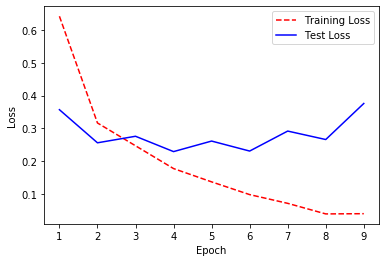

In [30]:
# https://chrisalbon.com/deep_learning/keras/visualize_loss_history/

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Evaluation - Top Model

- **MODEL_ID** `9d01c36a-5654-4858-8343-e9b923b9bfc5`
- **EPOCH** `7`

On training and cross-validation datasets:

```
loss: 0.1227 - accuracy: 0.9583 - val_loss: 0.2684 - val_accuracy: 0.9219
```

On test dataset:

```
loss: 0.2630712818354368 - accuracy: 0.92578125 
```

In [22]:
for model_path in model_dir.glob("*.h5"):
    model_file_path = str(model_path)
    print(model_path.parent.name, model_path.name)
    model = tf.keras.models.load_model(model_file_path)
    loss, acc = evaluate(model, test_dataset, batch_size, metadata["file_counts"]["test"])
    print("loss:", loss, "-", "accuracy:", acc, "\n")

9d01c36a-5654-4858-8343-e9b923b9bfc5 3.h5
loss: 0.33715570425348623 - accuracy: 0.8844866 

9d01c36a-5654-4858-8343-e9b923b9bfc5 7.h5
loss: 0.2630712818354368 - accuracy: 0.92578125 

9d01c36a-5654-4858-8343-e9b923b9bfc5 final.h5
loss: 0.361284109630755 - accuracy: 0.91657364 

9d01c36a-5654-4858-8343-e9b923b9bfc5 2.h5
loss: 0.43175008893013 - accuracy: 0.8523995 

9d01c36a-5654-4858-8343-e9b923b9bfc5 1.h5
loss: 0.5357408262789249 - accuracy: 0.82561386 

9d01c36a-5654-4858-8343-e9b923b9bfc5 6.h5
loss: 0.3111253138631582 - accuracy: 0.906808 

